In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import islice

In [2]:
df = pd.read_excel('RUS_NIOT_nov16.xlsx', sheet_name='National IO-tables')

In [3]:
df.columns

Index(['Year', 'Code', 'Description', 'Origin', 'A01', 'A02', 'A03', 'B',
       'C10-C12', 'C13-C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22',
       'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31_C32',
       'C33', 'D35', 'E36', 'E37-E39', 'F', 'G45', 'G46', 'G47', 'H49', 'H50',
       'H51', 'H52', 'H53', 'I', 'J58', 'J59_J60', 'J61', 'J62_J63', 'K64',
       'K65', 'K66', 'L68', 'M69_M70', 'M71', 'M72', 'M73', 'M74_M75', 'N',
       'O84', 'P85', 'Q', 'R_S', 'T', 'U', 'CONS_h', 'CONS_np', 'CONS_g',
       'GFCF', 'INVEN', 'EXP', 'GO'],
      dtype='object')

In [4]:
df_2013 = df[df['Year'] == 2013]
df_2014 = df[df['Year'] == 2014]
encoding = dict(zip(list(df_2013[df_2013['Origin'] == 'Domestic']['Code']), list(df_2013[df_2013['Origin'] == 'Domestic']['Description'])))

In [5]:
df_2013 = df_2013.drop(columns=['Description', 'Year'])
df_2014 = df_2014.drop(columns=['Description', 'Year'])

In [6]:
df_2013.columns

Index(['Code', 'Origin', 'A01', 'A02', 'A03', 'B', 'C10-C12', 'C13-C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26',
       'C27', 'C28', 'C29', 'C30', 'C31_C32', 'C33', 'D35', 'E36', 'E37-E39',
       'F', 'G45', 'G46', 'G47', 'H49', 'H50', 'H51', 'H52', 'H53', 'I', 'J58',
       'J59_J60', 'J61', 'J62_J63', 'K64', 'K65', 'K66', 'L68', 'M69_M70',
       'M71', 'M72', 'M73', 'M74_M75', 'N', 'O84', 'P85', 'Q', 'R_S', 'T', 'U',
       'CONS_h', 'CONS_np', 'CONS_g', 'GFCF', 'INVEN', 'EXP', 'GO'],
      dtype='object')

In [7]:
def create_matrix(df):
    df = df[df['Origin'] == 'Domestic']
    indices = list(df[df['GO'] == 0]['Code'])
    for i in indices:
        df = df[df['Code'] != i]
    df = df.drop(columns=indices)
    # df['GO'] = pd.sum(df, axis=1)
    new_indices = sorted(list({
            'A01', 'A02', 'A03', 'B',
            'C10-C12', 'C13-C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22',
            'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31_C32',
            'C33', 'D35', 'E36', 'E37-E39', 'F', 'G45', 'G46', 'G47', 'H49', 'H50',
            'H51', 'H52', 'H53', 'I', 'J58', 'J59_J60', 'J61', 'J62_J63', 'K64',
            'K65', 'K66', 'L68', 'M69_M70', 'M71', 'M72', 'M73', 'M74_M75', 'N',
            'O84', 'P85', 'Q', 'R_S', 'T', 'U'
        } - set(indices)))
    A = df[new_indices].to_numpy(dtype='float32')
    A = A[0:len(new_indices)][0:len(new_indices)]
    divisor = df['GO'].to_numpy(dtype='float32')
    A = A/divisor
    return A, new_indices, divisor

In [8]:
A_2013, new_indices_2013, X_2013 = create_matrix(df_2013)
A_2014, new_indices_2014, X_2014 = create_matrix(df_2014)
print(new_indices_2014)

['A01', 'B', 'C10-C12', 'C13-C15', 'C16', 'C17', 'C19', 'C20', 'C22', 'C23', 'C24', 'C26', 'C28', 'C29', 'C31_C32', 'D35', 'F', 'G45', 'G46', 'G47', 'H49', 'H50', 'H51', 'H52', 'I', 'J61', 'K64', 'L68', 'N', 'O84', 'P85', 'Q', 'R_S']


In [9]:
def check_productivity(A):
    D = np.eye(A.shape[0]) - A
    for i in range(0, D.shape[0]):
        minor = D[0:i+1,0:i+1]

        if np.linalg.det(minor) <= 0:
            print(f'Minor of {i}th degree is not positive')
            return False
    print('A is productive')
    return True

In [10]:
check_productivity(A_2013)
check_productivity(A_2014)

A is productive
A is productive


True

In [11]:
def construct_demands(A):
    d = np.sum(A, axis=1) - np.diag(A)
    dd = np.sum(A @ A, axis=1)  - np.diag(A @ A)
    d = dict(enumerate(d))
    dd = dict(enumerate(dd))
    return [d, dd]

In [12]:
d_2013, dd_2013 = construct_demands(A_2013)
print(max(d_2013.values()))
print(min(d_2013.values()))
print()
print(max(dd_2013.values()))
print(min(dd_2013.values()))

1.5616933
0.0040288605

0.8155227
0.0022743386


In [13]:
d_2014, dd_2014 = construct_demands(A_2014)
print(max(d_2014.values()))
print(min(d_2014.values()))
print()
print(max(dd_2014.values()))
print(min(dd_2014.values()))

1.5984546
0.004992623

0.7915186
0.0029505843


In [14]:
def construct_graph_demands(d, A, indices, threshold=0, n=5):
    edges = list()
    nodes = list()
    if n >= A.shape[0]:
        raise(ValueError(f'n must be less than {A.shape[0]}, given {n}'))
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if i == j:
                continue
            if A[i][j] >= threshold:
                if i not in nodes:
                    nodes.append(i)
                if j not in nodes:
                    nodes.append(j)
                edges.append((indices[i], indices[j]))
    size_based = 10000
    # size of nodes array
    summ_d = sum(d.values())
    eps = 1e-5
    sizes = list()
    for i in nodes:
        sizes.append((eps + d[i]) / summ_d * size_based)
    d = sorted(d.items(), key=lambda x: x[1])
    top_n_indices = d[len(d) - 1:len(d) - 1 - n:-1]
    g = nx.DiGraph(edges)
    pos = nx.circular_layout(g)
    nx.draw(g, pos, node_size=sizes, node_color='black')
    d = dict(d)
    labels = list(d.keys())
    nx.draw_networkx_labels(g, pos, font_size=10, font_family="sans-serif", font_color='red')
    top_n = []
    for i in top_n_indices:
        top_n.append(indices[i[0]])
    return top_n
    

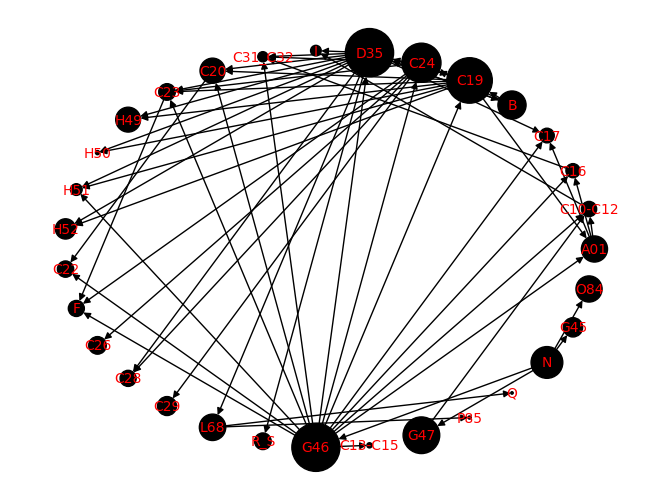

In [15]:
threshold = 0.05
n = 5
top_n_d_2013=construct_graph_demands(d_2013, A_2013, new_indices_2013, threshold, n)

In [16]:
print(f'top {n} for d_2013:{[encoding[i] for i in top_n_d_2013]}')

top 5 for d_2013:['Electricity, gas, steam and air conditioning supply', 'Wholesale trade, except of motor vehicles and motorcycles', 'Manufacture of coke and refined petroleum products ', 'Manufacture of basic metals', 'Retail trade, except of motor vehicles and motorcycles']


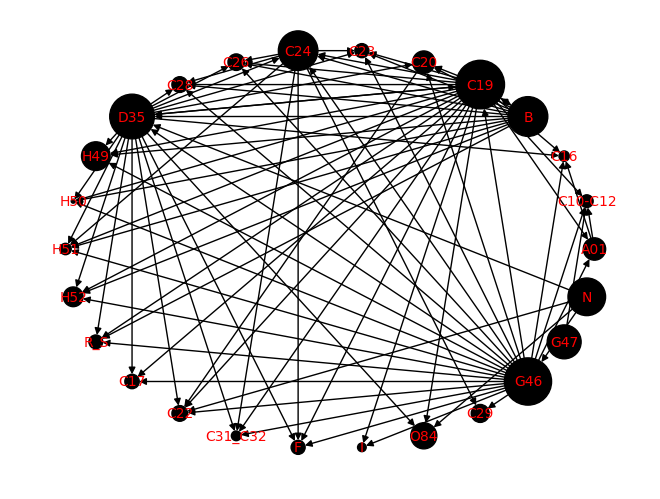

In [17]:
threshold = 0.02
n = 5
top_n_dd_2013 = construct_graph_demands(dd_2013, A_2013 @ A_2013, new_indices_2013, threshold, n)

In [18]:
print(f'top {n} for dd_2013:{[encoding[i] for i in top_n_dd_2013]}')

top 5 for dd_2013:['Manufacture of coke and refined petroleum products ', 'Wholesale trade, except of motor vehicles and motorcycles', 'Electricity, gas, steam and air conditioning supply', 'Mining and quarrying', 'Manufacture of basic metals']


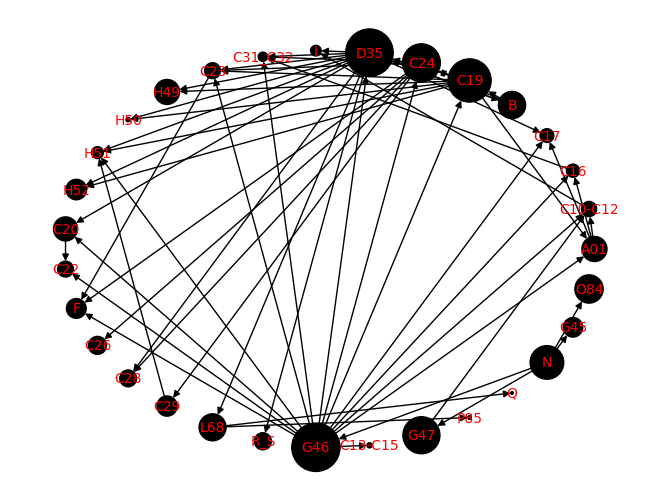

In [19]:
threshold = 0.05
n = 5
top_n_d_2014=construct_graph_demands(d_2014, A_2014, new_indices_2014, threshold, n)

In [20]:
print(f'top {n} for d_2014:{[encoding[i] for i in top_n_d_2014]}')

top 5 for d_2014:['Wholesale trade, except of motor vehicles and motorcycles', 'Electricity, gas, steam and air conditioning supply', 'Manufacture of coke and refined petroleum products ', 'Manufacture of basic metals', 'Retail trade, except of motor vehicles and motorcycles']


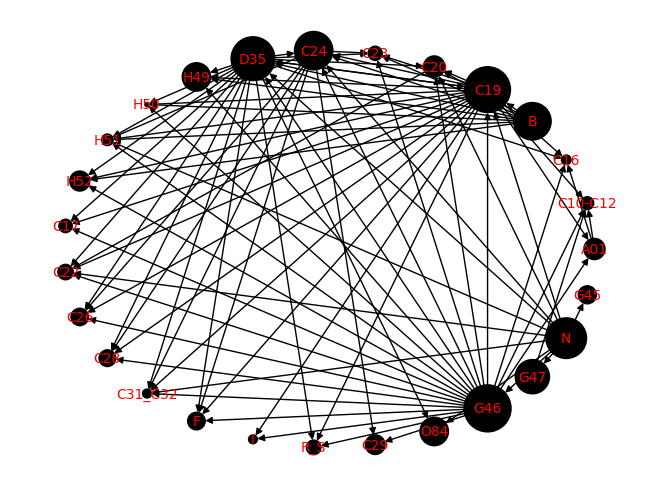

In [21]:
threshold = 0.02
n = 5
top_n_dd_2014=construct_graph_demands(dd_2014, A_2014 @ A_2014, new_indices_2014, threshold, n)

In [22]:
print(f'top {n} for dd_2014:{[encoding[i] for i in top_n_dd_2014]}')

top 5 for dd_2014:['Wholesale trade, except of motor vehicles and motorcycles', 'Manufacture of coke and refined petroleum products ', 'Electricity, gas, steam and air conditioning supply', 'Administrative and support service activities', 'Manufacture of basic metals']


*Часть 2*

In [23]:
def frob_perr(A, max_iter):
    n = A.shape[0]
    y = np.random.randn(n)
    lambda_1 = 0
    for i in range(max_iter):
        next_y = A @ y
        lambda_1 = next_y @ y.T / (y @ y.T)
        y = next_y / np.linalg.norm(y)
    if any(y < 0):
        y = -y
        if any(y < 0):
            print('Some error')
    return [lambda_1, y]
    

In [24]:
a = np.array(
    [
        [0,2,3],
        [4,0,6],
        [7,8,0]
    ]
)

print(q := frob_perr(a, 100))
print(np.linalg.eig(a))
print(a @ q[1].T)
print(q[0] * q[1].T)
print(np.linalg.det(a - q[0] * np.eye(*a.shape)))


[np.float64(9.768639238445887), array([3.37006952, 5.76108237, 7.13294287])]
EigResult(eigenvalues=array([ 9.76863924, -2.5540266 , -7.21461264]), eigenvectors=array([[-0.34498864, -0.76625718, -0.17570939],
       [-0.5897528 ,  0.58718488, -0.57005712],
       [-0.73018797,  0.26089049,  0.80259647]]))
[32.92099334 56.27793528 69.67914558]
[32.92099334 56.27793528 69.67914558]
-7.857106019250227e-12


In [25]:
q_2013 = frob_perr(A_2013, 100)
q_2014 = frob_perr(A_2014, 100)

In [26]:
print(f'lambda_A_2013 = {q_2013[0]:.5f}, x_A_2013 = {q_2013[1]}')
print(f'lambda_A_2014 = {q_2014[0]:.5f}, x_A_2014 = {q_2014[1]}')

lambda_A_2013 = 0.45931, x_A_2013 = [0.01811223 0.15345025 0.00888324 0.00113189 0.00723843 0.01586818
 0.22029623 0.03693368 0.02087258 0.01512364 0.1312167  0.02491888
 0.02201392 0.02966568 0.00822398 0.1846401  0.01680275 0.02444404
 0.18059729 0.08803071 0.07689707 0.00131675 0.01093942 0.03231453
 0.00700851 0.04548643 0.0335817  0.04413696 0.15864978 0.06147824
 0.00077218 0.0006073  0.01787099]
lambda_A_2014 = 0.46616, x_A_2014 = [0.01686745 0.13862293 0.00965051 0.0011432  0.00667704 0.01429443
 0.19929714 0.03444583 0.02091913 0.01634808 0.13029976 0.02956341
 0.0256638  0.03783112 0.00714939 0.1822531  0.02750452 0.02576144
 0.18343949 0.09262259 0.07619873 0.00154056 0.01158477 0.03414701
 0.00779081 0.04772988 0.04051853 0.05118917 0.19796477 0.07516574
 0.00119894 0.00079825 0.02099992]


In [27]:
def exclude_some_indices(A, d, dd):
    d = sorted(d.items(), key=lambda x: x[1])
    to_del_d = [d[i][0] for i in range(5)]
    dd = sorted(dd.items(), key=lambda x: x[1])
    to_del_dd = [dd[i][0] for i in range(5)]
    s_to_del = set(to_del_d) | set(to_del_d)
    ind = list(set(range(A.shape[0])) - s_to_del)
    A_11 = A[ind, :][:, ind].reshape((-1, len(ind)))
    A_22 = A[list(s_to_del), :][:, list(s_to_del)].reshape((-1, len(s_to_del)))
    A_21 = A[list(s_to_del), :][:, ind].reshape((-1, len(ind)))
    A_12 = A[ind, :][:, list(s_to_del)].reshape((len(ind), -1))
    B = A_11 - A_12 @ np.linalg.inv(np.eye(len(s_to_del)) - A_22) @ A_21
    return B

In [28]:
new_A_2013 = exclude_some_indices(A_2013, d_2013, dd_2013)
q_ex_2013 = frob_perr(new_A_2013, 1000)[0]

In [29]:
new_A_2014 = exclude_some_indices(A_2014, d_2014, dd_2014)
q_ex_2014 = frob_perr(new_A_2014, 1000)[0]

In [30]:
from itertools import product
def aggregate_some_indices(A, d, x, eps):
    d = sorted(d.items(), key=lambda x: x[1])
    ind_1 = set([d[0][0]])
    while True:
        new_ind_1 = ind_1.copy()
        for i in range(len(d)):
            for j in range(len(ind_1)):
                if i in new_ind_1:
                    continue
                if (A[i][j] > eps) and (A[j][i] > eps):
                    new_ind_1.add(i)
                    break
        if new_ind_1 == ind_1:
            break
        ind_1 = new_ind_1
    ind_2 = list(set(range(A.shape[0])) - ind_1)
    ind_1 = list(ind_1)
    B = np.zeros((1 + len(ind_2), 1 + len(ind_2)))
    for k in range(1 + len(ind_2)):
        for s in range(1 + len(ind_2)):
            if k == 0:
                if s == 0:
                    denominator = sum(x[ind_1])
                    numerator = 0
                    for i,j in product(ind_1, repeat=2):
                        numerator += (A[i][j] * x[j])
                    B[k][s] = numerator / denominator
                else:
                    B[k][s] = sum(A[:,ind_2[s - 1]])
            else:
                if s == 0:
                    B[k][s] = sum(A[ind_2[k - 1], :]) / (sum(x[ind_1]))
                else:
                    B[k][s] = A[ind_2[k - 1]][ind_2[s - 1]]
    return B

In [31]:
agg_A_2013 = aggregate_some_indices(A_2013, d_2013, X_2013, 0.01)
q_agg_2013 = frob_perr(agg_A_2013, 100)[0]

In [32]:
agg_A_2014 = aggregate_some_indices(A_2014, d_2014, X_2014, 0.01)
q_agg_2014 = frob_perr(agg_A_2014, 100)[0]

In [33]:
print(f'inv_frob_perr_num_2013 = {1 / q_2013[0]}, inv_frob_perr_num_2014 = {1 / q_2014[0]}')
print(f'inv_frob_perr_num_agg_2013 = {1 / q_agg_2013}, inv_frob_perr_num_agg_2014 = {1 / q_agg_2014}')
print(f'inv_frob_perr_num_ex_2013 = {1 / q_ex_2013}, inv_frob_perr_num_ex_2014 = {1 / q_ex_2014}')


inv_frob_perr_num_2013 = 2.1771648034969093, inv_frob_perr_num_2014 = 2.1451820427359034
inv_frob_perr_num_agg_2013 = 2.4031341883867077, inv_frob_perr_num_agg_2014 = 2.276799029175675
inv_frob_perr_num_ex_2013 = 2.2040060645407142, inv_frob_perr_num_ex_2014 = 2.168746957020812
